# Dimensionality reduction and clustering of movement types
Apr2023 \
author: Inês Laranjeira

In [64]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import re
from mpl_toolkits.mplot3d import Axes3D

from brainbox.task.trials import find_trial_ids
from brainbox.behavior.training import get_sessions, get_training_status
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from one.api import ONE

one = ONE()

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, KFold, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get my functions
functions_path = "../Functions/"
os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/tmpgz_jrmn4/cache.zip Bytes: 95015420


100%|██████████| 90.61376571655273/90.61376571655273 [00:23<00:00,  3.91it/s]


## Functions
### Need to move to separate file

In [139]:
def stack_trials(time, position, trials, event, t_init, t_end):

    wheel_df = pd.DataFrame({'time':time, 'position':position})
    onset_times = trials[event]
    # Start a matrix with #trials x # wheel bins
    wheel_stack = np.zeros((len(onset_times), 500)) * np.nan  # TODO: should not to be hard-coded

    for t, trial_onset in enumerate(onset_times):
        if np.isnan(trial_onset) == False:
            if len(wheel_df.loc[wheel_df['time'] > trial_onset, 'time']) > 0:
                trial_onset_index = wheel_df.loc[wheel_df['time'] > trial_onset, 'time'].reset_index()['index'][0]
                onset_position = wheel_df['position'][trial_onset_index]
                #trial_feedback = list(preprocessed_data['correct'])[t]

                # Populate dataframe with useful trial-aligned information
                wheel_stack[t, :] = wheel_df.loc[(wheel_df['time']> trial_onset-t_init) & (wheel_df['time'] <= trial_onset+t_end), 'position'] - onset_position 
    return wheel_stack

## Get training data

In [4]:
# Get subjects of interest
subjects_of_interest = query_subjects_interest(protocol='training', ibl_project='ibl_neuropixel_brainwide_01')
#data = subjects_interest_data(subjects_of_interest)
data = subjects_interest_data(['KS014'])

## Load wheel data

In [152]:
sessions = data['session'].unique()
t_init = 0  # time to plot before stimulus onset
t_end = 0.5 # time to plot after stimulus onset

all_wheel = pd.DataFrame()
# Loop through sessions (could put this inside an animal loop)
for s, session in enumerate(sessions[10:11]):
    # Get session data
    eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
    eid = session
    wheel = one.load_object(eid, 'wheel', collection='alf')
    wheelMoves = one.load_object(eid, 'wheelMoves', collection='alf')
    trials_data = data.loc[data['session']==eid]
    processed_data = prepro(trials_data)

    # Get wheel data for that session
    pos, time = wh.interpolate_position(wheel.timestamps, wheel.position)

    wheel_stack = pd.DataFrame(stack_trials(time=time, position=pos, trials=processed_data, event='stimOn_times', t_init = 0, t_end = 0.5))
    
    if s == 0:
        all_wheel = wheel_stack.copy()
        all_wheel['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
        all_wheel['session_number'] = s + 1
        all_wheel['feedback'] = list(processed_data['correct'])
        all_wheel['choice'] = list(processed_data['choice'])
    else:
        wheel_stack['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
        wheel_stack['session_number'] = s + 1
        wheel_stack['feedback'] = list(processed_data['correct'])
        wheel_stack['choice'] = list(processed_data['choice'])
        all_wheel = all_wheel.append(wheel_stack)


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/one_functions_generic.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/one_functions_generic.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastRight'] = trials['contrastRight'].fillna(0)
/Users/ineslaranjeira/Documents/Repositories/representation_

## Build design matrix

In [153]:

"""
PRE-PROCESSING - select features of interest
"""
no_use_var = ['mouse_name', 'session_number', 'feedback']  # original results
clean_wheel = all_wheel.dropna()
matrix = clean_wheel.drop(columns=no_use_var)
full_matrix = all_wheel
ref_df = clean_wheel[no_use_var]

"""
PRINCIPLE COMPONENT ANALYSES
"""

X_df = matrix.dropna()
X = np.array(X_df) # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))

Text(0, 0.5, '% Variance explained')

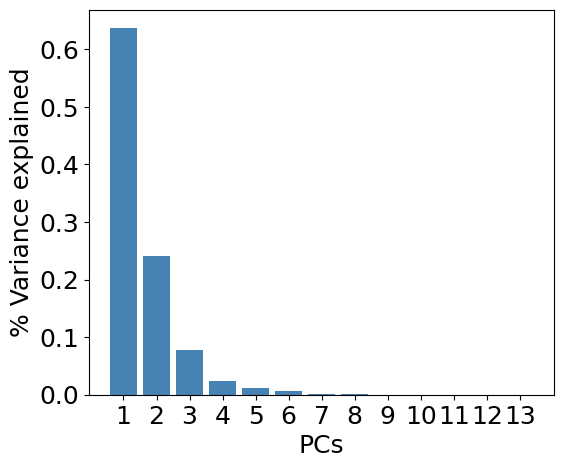

In [154]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = 13
plt.bar(np.arange(1, 13+1, 1), pca.explained_variance_ratio_[0:13], color='steelblue')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [155]:
# Plot projections of datapoints into first 3 principal components

ref_df['pc1'] = X_reduced[:, 0].transpose()
ref_df['pc2'] = X_reduced[:, 1].transpose()
ref_df['pc3'] = X_reduced[:, 2].transpose()
ref_df['pc4'] = X_reduced[:, 3].transpose()


fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
           cmap=plt.cm.Set1, edgecolor='k', s=40) # cmap=plt.cm.Set1
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/2644673357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['pc1'] = X_reduced[:, 0].transpose()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/2644673357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['pc2'] = X_reduced[:, 1].transpose()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/2644673357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='pc1', ylabel='pc2'>

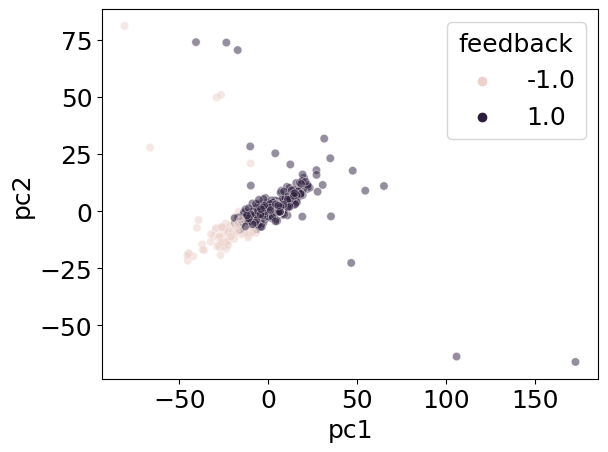

In [156]:
sns.scatterplot(x='pc1', y='pc2', hue='feedback', data=ref_df, alpha=0.5)

In [157]:
sns.scatterplot(x='pc1', y='pc2', hue='choice', data=ref_df, alpha=0.5)

ValueError: Could not interpret value `choice` for parameter `hue`

In [123]:
ref_df

,mouse_name,session_number,pc1,pc2,pc3,pc4
0,KS014,1,0.951264,1.601649,4.880069,-1.251334
1,KS014,1,40.617768,0.236341,8.030599,-3.741929
2,KS014,1,-3.729428,13.329869,8.654804,3.290574
3,KS014,1,21.894081,-3.719067,5.393991,2.913909
4,KS014,1,9.544072,0.794713,0.265835,-0.245322
...,...,...,...,...,...,...
837,KS014,13,15.622073,-2.700782,1.267575,2.149842
838,KS014,13,-13.798856,-1.435871,-2.075169,-1.844436
839,KS014,13,8.881542,0.237115,0.401737,-0.154916
840,KS014,13,18.658921,-4.195861,3.648657,2.753274


In [101]:
"""
Average across sessions
"""
ref_df['pc1'] = X_reduced[:, 0].transpose()
ref_df['pc2'] = X_reduced[:, 1].transpose()
ref_df['pc3'] = X_reduced[:, 2].transpose()
ref_df['pc4'] = X_reduced[:, 3].transpose()


avg_trans = ref_df.groupby(['mouse_name', 'session_number']).agg(
     avg_1=pd.NamedAgg(column="pc1", aggfunc=np.mean),
     avg_2=pd.NamedAgg(column="pc2", aggfunc=np.mean),
     avg_3=pd.NamedAgg(column="pc3", aggfunc=np.mean),
     avg_4=pd.NamedAgg(column="pc4", aggfunc=np.mean),
     std_1=pd.NamedAgg(column="pc1", aggfunc=np.std),
     std_2=pd.NamedAgg(column="pc2", aggfunc=np.std),
     std_3=pd.NamedAgg(column="pc3", aggfunc=np.std),
     std_4=pd.NamedAgg(column="pc4", aggfunc=np.std),
     )
avg_trans = avg_trans.reset_index(level=[0, 1])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/3285437427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['pc1'] = X_reduced[:, 0].transpose()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/3285437427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['pc2'] = X_reduced[:, 1].transpose()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_85255/3285437427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [102]:
avg_trans

,mouse_name,session_number,avg_1,avg_2,avg_3,avg_4,std_1,std_2,std_3,std_4
0,KS014,1,24.938098,-1.135943,3.477266,0.368813,24.005246,7.514842,5.551713,3.224062
1,KS014,2,-5.418495,-0.902079,-2.047378,2.991251,13.223381,10.194520,6.368267,4.816949
2,KS014,3,5.301233,1.106639,-1.314933,0.731776,13.190109,5.377209,3.726232,2.326463
3,KS014,4,1.580379,-0.778161,-0.519239,-2.060907,32.163787,18.383719,11.021978,6.004025
4,KS014,5,-5.220093,5.376178,-2.921357,1.847844,20.482229,14.165310,9.372963,5.464121
5,KS014,6,0.734566,-8.667919,2.890499,2.944296,17.958740,11.057049,7.642237,5.383774
6,KS014,7,6.951269,-0.847161,2.084875,-0.191515,12.630574,6.828905,4.457252,2.287683
7,KS014,8,-4.420445,-4.352192,4.419681,-3.091700,33.715135,13.785390,9.213692,6.395087
8,KS014,9,-11.753979,5.821568,-4.555181,-2.111562,27.462136,15.389236,9.493150,5.811058
9,KS014,10,2.195305,-9.667187,8.452639,-1.975633,22.275747,9.702638,7.615339,5.750062


<Axes: xlabel='avg_3', ylabel='avg_2'>

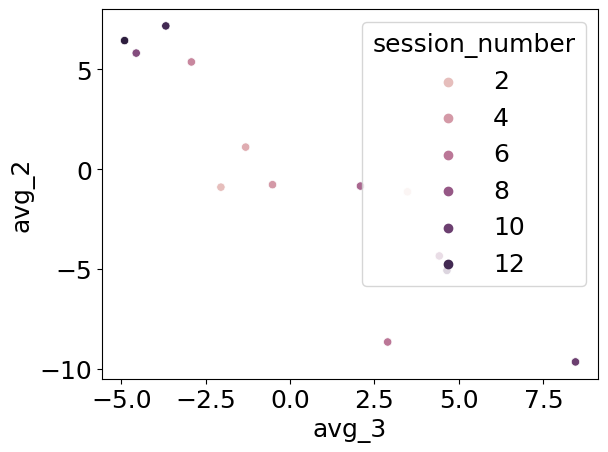

In [109]:
sns.scatterplot(x='avg_3', y='avg_2', hue='session_number', data=avg_trans)

In [ ]:
    
x = avg_trans['avg_1']
y = avg_trans['avg_2']
xerr = avg_trans['std_1']/np.sqrt(np.sum(mice['quantile']==qua))
yerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_2']/np.sqrt(np.sum(mice['quantile']==qua))


ax.errorbar(x, y,
        xerr=xerr,
        yerr=yerr,
        fmt='-o',
        color=flatui[q],
        alpha=0.7)



"""
Get mice and corresponding quartiles
"""
mice = metrics_sorted.dropna().groupby(['subject_uuid']).agg(
     quantile=pd.NamedAgg(column="quantile", aggfunc=np.mean),
     )
mice = mice.reset_index(level=[0])


quartiles = [1., 2., 3., 4.]
#quartiles = [1., 2., 3.]

flatui = ["#9b59b6", "#34495e", "#95a5a6", "#3498db"] # , "#95a5a6",  "#34495e"
quartile_start = ['First bin - Quartile 1', 'First bin - Quartile 2', 'First bin - Quartile 3', 'First bin - Quartile 4']

fig, ax = plt.subplots(figsize=[10,8])

for q, qua in enumerate(quartiles):
    
    x = avg_trans.loc[avg_trans['quantile']==qua, 'avg_1']
    y = avg_trans.loc[avg_trans['quantile']==qua, 'avg_2']
    xerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_1']/np.sqrt(np.sum(mice['quantile']==qua))
    yerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_2']/np.sqrt(np.sum(mice['quantile']==qua))


    ax.errorbar(x, y,
            xerr=xerr,
            yerr=yerr,
            fmt='-o',
            color=flatui[q],
            alpha=0.7)
    

    if q==1:
        
        ax.scatter(list(x)[0], list(y)[0], marker='^', s=500, color=flatui[q], label='First bin')
        ax.scatter(list(x)[-1], list(y)[-1], marker='v', s=500, color=flatui[q], label='Last bin')
    else:
        ax.scatter(list(x)[0], list(y)[0], marker='^', s=500, color=flatui[q])
        ax.scatter(list(x)[-1], list(y)[-1], marker='v', s=500, color=flatui[q])


ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.legend()
plt.show()